# Kinyarwanda Text Auto-Completion Using a Bi-LSTM model, without Attention.

In [ ]:
!nvidia-smi

Fri Dec  8 13:02:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torchsummaryX

In [ ]:
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 14.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import os
import re
import wandb
import torchsummaryX
import pandas as pd
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# !unzip /content/filtered_datasets_v2-20231208T090952Z-001.zip #uncomment if the dataset is uploaded as a zipped folder

Archive:  /content/filtered_datasets_v2-20231208T090952Z-001.zip
  inflating: filtered_datasets_v2/dictionary.txt  
  inflating: filtered_datasets_v2/txtData.txt  
  inflating: filtered_datasets_v2/NP/newsarticles.txt_135900_.npy  
  inflating: filtered_datasets_v2/newsarticles.txt  
  inflating: filtered_datasets_v2/NP/newsarticles.txt_136873_.npy  
  inflating: filtered_datasets_v2/NP/corpus1.txt_3200_.npy  
  inflating: filtered_datasets_v2/NP/corpus1.txt_1300_.npy  
  inflating: filtered_datasets_v2/NP/newsarticles.txt_136800_.npy  
  inflating: filtered_datasets_v2/NP/corpus1.txt_1800_.npy  
  inflating: filtered_datasets_v2/NP/corpus1.txt_4300_.npy  
  inflating: filtered_datasets_v2/NP/corpus1.txt_100_.npy  
  inflating: filtered_datasets_v2/NP/corpus1.txt_1700_.npy  
  inflating: filtered_datasets_v2/NP/corpus1.txt_5800_.npy  
  inflating: filtered_datasets_v2/NP/corpus1.txt_3400_.npy  
  inflating: filtered_datasets_v2/NP/corpus1.txt_7300_.npy  
  inflating: filtered_datasets_

### Defining global variables and helper functions.

In [ ]:
DICTIONARY_PATH = "/content/filtered_datasets_v2/dictionary.txt"
DICTIONARY_list =  np.loadtxt(DICTIONARY_PATH, dtype= str)
DICTIONARY_dict = {word: idx for idx, word in enumerate(DICTIONARY_list)}
SOS_IDX = DICTIONARY_dict["<sos>"]
EOS_IDX = DICTIONARY_dict["<eos>"]
UNK_IDX = DICTIONARY_dict["<unk>"]
print("SOS_IDX:",SOS_IDX,"EOS_IDX:",EOS_IDX,"UNK_IDX:", UNK_IDX)

SOS_IDX: 2 EOS_IDX: 1 UNK_IDX: 3


In [ ]:
def get_files_in_directory(directory_path):
    """
    This function returns a list of filenames in a
    specific directory path.
    """
    files = []
    for file in os.listdir(directory_path):
        if os.path.isfile(os.path.join(directory_path, file)):
            files.append(file)
    return files

In [ ]:
PATH_TO_NPY_DATA = "/content/filtered_datasets_v2/NP"
NPY_FILENAMES = sorted(get_files_in_directory(PATH_TO_NPY_DATA))
print(NPY_FILENAMES)

['corpus1.txt_100_.npy', 'corpus1.txt_1300_.npy', 'corpus1.txt_1400_.npy', 'corpus1.txt_1500_.npy', 'corpus1.txt_1600_.npy', 'corpus1.txt_1700_.npy', 'corpus1.txt_1800_.npy', 'corpus1.txt_1900_.npy', 'corpus1.txt_2000_.npy', 'corpus1.txt_200_.npy', 'corpus1.txt_2800_.npy', 'corpus1.txt_2900_.npy', 'corpus1.txt_3000_.npy', 'corpus1.txt_300_.npy', 'corpus1.txt_3100_.npy', 'corpus1.txt_3200_.npy', 'corpus1.txt_3300_.npy', 'corpus1.txt_3400_.npy', 'corpus1.txt_3500_.npy', 'corpus1.txt_400_.npy', 'corpus1.txt_4300_.npy', 'corpus1.txt_500_.npy', 'corpus1.txt_5800_.npy', 'corpus1.txt_7300_.npy', 'newsarticles.txt_100000_.npy', 'newsarticles.txt_10000_.npy', 'newsarticles.txt_1000_.npy', 'newsarticles.txt_100100_.npy', 'newsarticles.txt_100200_.npy', 'newsarticles.txt_100300_.npy', 'newsarticles.txt_100400_.npy', 'newsarticles.txt_100500_.npy', 'newsarticles.txt_100600_.npy', 'newsarticles.txt_100700_.npy', 'newsarticles.txt_100800_.npy', 'newsarticles.txt_100900_.npy', 'newsarticles.txt_100_.

### Train & Test data splitting

In [ ]:
import random

#  Set a seed for reproducibility
random.seed(42)

# Shuffle the list of file names
random.shuffle(NPY_FILENAMES)

# Define the split ratio (e.g., 80% training, 20% testing)
split_ratio = 0.8
split_index = int(len(NPY_FILENAMES) * split_ratio)

# Split the files into training and testing sets
train_files = NPY_FILENAMES[:split_index]
test_files = NPY_FILENAMES[split_index:]
train_files = [os.path.join(PATH_TO_NPY_DATA, i) for i in train_files]
test_files = [os.path.join(PATH_TO_NPY_DATA, i) for i in test_files]

### Creating the Datasets and Dataloaders Objects.

In [ ]:
N = 4 # This can be changed to any unsigned int. However, the range used in experiments was 2 to 7.

In [ ]:
class N_gramDataset(Dataset):
    def __init__(self, data_filepaths_list,
                 sos_idx = SOS_IDX, eos_idx = EOS_IDX,
                 sequence_length=100, max_output_rows = 100,
                 shuffle=False):

        self.data_filepaths_list = data_filepaths_list
        self.length = len(data_filepaths_list)
        self.sos_idx, self.eos_idx = sos_idx, eos_idx
        self.shuffle = shuffle
        self.sequence_length = sequence_length
        self.max_output_rows=max_output_rows
        # self.input_indices = input_indices
        # self.output_indices = output_indices


    def __len__(self):
        # return len(self.input_indices)
        return self.length

    def __getitem__(self, idx):
        # return torch.LongTensor(self.input_indices[idx]), torch.LongTensor(self.output_indices[idx])
        filepath = self.data_filepaths_list[idx]
        sequences = np.load(filepath, allow_pickle = True)
        if self.shuffle:
            sequences = np.random.permutation(sequences)
        new_sequences = []
        for article_id,article_ in enumerate(sequences):
            new_sequences.append(torch.LongTensor(np.append(np.append(np.array([self.sos_idx]), article_), np.array([self.eos_idx]))))
        new_sequences = torch.cat(new_sequences)
        num_batches = len(new_sequences) // (self.sequence_length + 1)
        X = torch.zeros((num_batches, self.sequence_length+1), dtype=torch.long)
        for batch_idx in range(num_batches):
            start_idx = batch_idx * self.sequence_length
            end_idx = start_idx + self.sequence_length + 1
            X[batch_idx,:] = new_sequences[start_idx:end_idx]
        return X[:self.max_output_rows,:-1], X[:self.max_output_rows,1:]

# Create datasets and dataloaders
train_dataset = N_gramDataset(data_filepaths_list= train_files,sequence_length=N,max_output_rows=28, shuffle = True)
val_dataset = N_gramDataset(data_filepaths_list= test_files,sequence_length=N, shuffle = False)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [ ]:
for X__, y___ in train_loader:
  print(X__.shape, y___.shape)
  break

torch.Size([1, 28, 4]) torch.Size([1, 28, 4])


In [ ]:
print(X__[0][5], y___[0][5])

tensor([11976,  9705,  9660,     3]) tensor([ 9705,  9660,     3, 16257])


In [ ]:
# del model
torch.cuda.empty_cache()

### Defining the Model.

In [ ]:
class BiLSTM_N_gramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(BiLSTM_N_gramModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        self.fc = torch.nn.Sequential(nn.Linear(hidden_size * 2, embedding_dim),
                                      nn.Linear(embedding_dim, vocab_size),)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.bilstm(embedded)
        logits = self.fc(output)
        return logits

# Initialize the model
vocab_size = len(DICTIONARY_list)
embedding_dim = 300
hidden_size = 256

model = BiLSTM_N_gramModel(vocab_size, embedding_dim, hidden_size).to(DEVICE)


In [ ]:
vocab_size

18737

In [ ]:
print(model)
torchsummaryX.summary(model, x = X__[0].to(DEVICE))

BiLSTM_N_gramModel(
  (embedding): Embedding(18737, 300)
  (bilstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=18737, bias=True)
  )
)
               Kernel Shape    Output Shape   Params  Mult-Adds
Layer                                                          
0_embedding    [300, 18737]    [28, 4, 300]  5621100    5621100
1_bilstm                  -    [28, 4, 512]  1142784    1138688
2_fc.Linear_0    [512, 300]    [28, 4, 300]   153900     153600
3_fc.Linear_1  [300, 18737]  [28, 4, 18737]  5639837    5621100
---------------------------------------------------------------
                        Totals
Total params          12557621
Trainable params      12557621
Non-trainable params         0
Mult-Adds             12534488


/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_embedding,"[300, 18737]","[28, 4, 300]",5621100,5621100
1_bilstm,-,"[28, 4, 512]",1142784,1138688
2_fc.Linear_0,"[512, 300]","[28, 4, 300]",153900,153600
3_fc.Linear_1,"[300, 18737]","[28, 4, 18737]",5639837,5621100


In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Initializing the Wandb logistics.

In [ ]:
import wandb
wandb.login(key="e3bf5278ada5cb1d98a6cb7230ec2645def6034b")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
run = wandb.init(
    name = f"lstm_project_{N}_gram",
    reinit = True,
    # id ='tpidwt8b',
    # resume = "must",
    project = "LSTM-ablations",
    config = config ### Wandb Config for your run
)

train_Acc,▁▆▇▇▇███████████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_Acc,▁▅▆▇▇▇██████████████
validation_loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_Acc,0.83383
train_loss,1.11609
validation_Acc,0.8291
validation_loss,1.16276


### Training & Evaluation

Validation: 100%|██████████| 277/277 [00:03<00:00, 77.34it/s]


Epoch 1/20, Training Loss: 4.5709, Validation Loss: 3.1733, Training Accuracy: 0.4389, Validation Accuracy: 0.5987
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 77.56it/s]


Epoch 2/20, Training Loss: 2.6639, Validation Loss: 2.3359, Training Accuracy: 0.6572, Validation Accuracy: 0.6976
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 77.64it/s]


Epoch 3/20, Training Loss: 2.1209, Validation Loss: 2.0199, Training Accuracy: 0.7197, Validation Accuracy: 0.7322
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 77.99it/s]


Epoch 4/20, Training Loss: 1.8951, Validation Loss: 1.8644, Training Accuracy: 0.7444, Validation Accuracy: 0.7489
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 76.93it/s]


Epoch 5/20, Training Loss: 1.7527, Validation Loss: 1.7644, Training Accuracy: 0.7585, Validation Accuracy: 0.7603
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 78.44it/s]


Epoch 6/20, Training Loss: 1.6748, Validation Loss: 1.6962, Training Accuracy: 0.7665, Validation Accuracy: 0.7663
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 77.81it/s]


Epoch 7/20, Training Loss: 1.6131, Validation Loss: 1.6470, Training Accuracy: 0.7739, Validation Accuracy: 0.7711
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 77.26it/s]


Epoch 8/20, Training Loss: 1.5726, Validation Loss: 1.6090, Training Accuracy: 0.7772, Validation Accuracy: 0.7748
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 77.51it/s]


Epoch 9/20, Training Loss: 1.5317, Validation Loss: 1.5780, Training Accuracy: 0.7809, Validation Accuracy: 0.7778
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 77.67it/s]


Epoch 10/20, Training Loss: 1.5159, Validation Loss: 1.5570, Training Accuracy: 0.7828, Validation Accuracy: 0.7813
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 75.49it/s]


Epoch 11/20, Training Loss: 1.4905, Validation Loss: 1.5365, Training Accuracy: 0.7856, Validation Accuracy: 0.7807


Validation: 100%|██████████| 277/277 [00:03<00:00, 78.09it/s]


Epoch 12/20, Training Loss: 1.4803, Validation Loss: 1.5218, Training Accuracy: 0.7857, Validation Accuracy: 0.7834
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 76.66it/s]


Epoch 13/20, Training Loss: 1.4696, Validation Loss: 1.5073, Training Accuracy: 0.7875, Validation Accuracy: 0.7842
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 79.24it/s]


Epoch 14/20, Training Loss: 1.4491, Validation Loss: 1.5020, Training Accuracy: 0.7887, Validation Accuracy: 0.7844
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 79.54it/s]


Epoch 15/20, Training Loss: 1.4377, Validation Loss: 1.4905, Training Accuracy: 0.7901, Validation Accuracy: 0.7855
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 78.67it/s]


Epoch 16/20, Training Loss: 1.4283, Validation Loss: 1.4849, Training Accuracy: 0.7902, Validation Accuracy: 0.7865
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 78.06it/s]


Epoch 17/20, Training Loss: 1.4224, Validation Loss: 1.4797, Training Accuracy: 0.7906, Validation Accuracy: 0.7857


Validation: 100%|██████████| 277/277 [00:03<00:00, 78.73it/s]


Epoch 18/20, Training Loss: 1.4231, Validation Loss: 1.4723, Training Accuracy: 0.7903, Validation Accuracy: 0.7867
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 78.93it/s]


Epoch 19/20, Training Loss: 1.4134, Validation Loss: 1.4695, Training Accuracy: 0.7911, Validation Accuracy: 0.7873
Saving model


Validation: 100%|██████████| 277/277 [00:03<00:00, 77.86it/s]


Epoch 20/20, Training Loss: 1.3980, Validation Loss: 1.4630, Training Accuracy: 0.7925, Validation Accuracy: 0.7879
Saving model


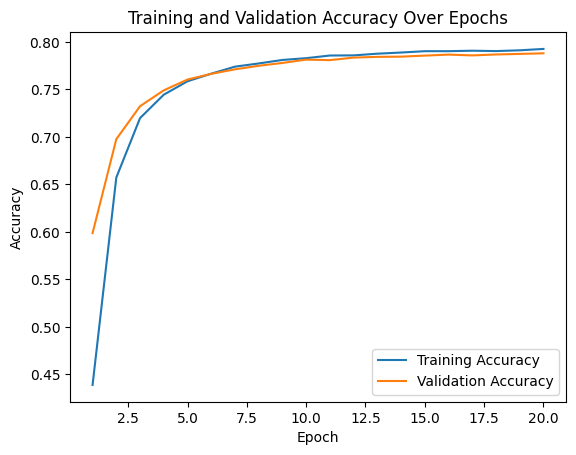

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize empty lists to store accuracy values
train_accuracies = []
val_accuracies = []
best_valacc = 0.0
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training', dynamic_ncols=True)

    for inputs, targets in train_loader_iter:
        inputs = inputs[0].to(DEVICE)
        targets = targets[0].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 2)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.numel()

    # Validation loss and accuracy
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_loader_iter = tqdm(val_loader, desc='Validation', dynamic_ncols=True)

        for inputs, targets in val_loader_iter:
            inputs = inputs[0].to(DEVICE)
            targets = targets[0].to(DEVICE)
            outputs = model(inputs)
            val_loss += criterion(outputs.view(-1, vocab_size), targets.view(-1)).item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 2)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.numel()

    average_train_loss = total_loss / len(train_loader)
    average_val_loss = val_loss / len(val_loader)

    # Calculate and store accuracies
    train_accuracy = correct_train / total_train
    val_accuracy = correct_val / total_val
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    wandb.log({"train_loss":average_train_loss, 'train_Acc': train_accuracy, 'validation_Acc':val_accuracy,
               'validation_loss': average_val_loss})

    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently
    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_accuracy >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'val_acc': val_accuracy,
                  'epoch': epoch}, '/content/Checkpoints/LSTM4_checkpoint.pth')
      best_valacc = val_accuracy
      wandb.save('/content/Checkpoints/LSTM4_checkpoint.pth')
# Plot the accuracy curve
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
"""
Uncomment this only when you are sure of what you are doing.
(The code below had been used to create a graph and a table of results
for the initial submission of the project.
However, after finding that Wandb can do the job, the code is kept commented.)
"""
# pd.DataFrame({f"{N}_gram_Train_accuracies": train_accuracies,
#               f"{N}_gram_Val_accuracies": val_accuracies}).to_csv(f"{N}_gram_training_curves.csv")
# # Plotting the results;
# training_curves_file_list = [f"{n_idx}_gram_training_curves.csv" for n_idx in range(2,8)]
# print(training_curves_file_list)
# def plot_train_val():
#   # Plot the accuracy curve
#   color_list = "rgbcymk"
#   for idx, n__ in enumerate(range(2,8)):
#     mpd=pd.read_csv(f"/content/{n__}_gram_training_curves.csv").rename(columns={'Unnamed: 0':"epoch"})
#     # plt.plot(mpd.epoch+1, mpd[f"{n__}_gram_Train_accuracies"],f"{color_list[idx]}:")
#     plt.plot(mpd.epoch+1, mpd[f"{n__}_gram_Val_accuracies"],f"{color_list[idx]}-",label=f"{n__}-Gram")
#   plt.xlabel('Epoch')
#   plt.ylabel('Accuracy')
#   plt.title('Validation Accuracy Over Epochs\n for N-gram models, N ranging from 2 to 7')
#   plt.legend(title="Legend")
#   plt.show()
# plot_train_val()
# Making the table:
# def make_table_of_results():
#   # Plot the accuracy curve

#   best_validation_accuracies = []
#   for idx, n__ in enumerate(range(2,8)):
#     mpd=pd.read_csv(f"/content/{n__}_gram_training_curves.csv").rename(columns={'Unnamed: 0':"epoch"})
#     # plt.plot(mpd.epoch+1, mpd[f"{n__}_gram_Train_accuracies"],f"{color_list[idx]}:")
#     best_validation_accuracies.append(list(dict(mpd.max()).values())[-1])
#   table_to_return = pd.DataFrame(
#       {
#           "":["Bi-gram","Tri-gram"] + [f"{i}-gram" for i in range(4,8)],
#           "Our approach": best_validation_accuracies
#       }
#   )
#   return table_to_return

# make_table_of_results()

### Inferencing: An example

In [ ]:
def predict_next_word(model, context, vocab_dict, index_dict, top_k = 3):
    model.eval()

    with torch.no_grad():
        # Convert context to indices
        context_indices = [vocab_dict.get(word, UNK_IDX) for word in context]
        input_tensor = torch.LongTensor(context_indices).unsqueeze(0)

        # Get model prediction
        output = model(input_tensor.to(DEVICE))
        # print(output.shape)
        predicted_index = torch.argmax(output[0, -1, :]).item()

        # Convert index to word
        predicted_word = index_dict.get(predicted_index, "<unk>")

        top_values, top_indices = torch.topk(torch.nn.Softmax(dim=0)(output[0, -1, :]), k=top_k)

        top_words = [index_dict.get(top_word, "<unk>") for top_word in top_indices.tolist()]


        top_k_dict = dict(zip(top_words, top_values.tolist()))

        print(f"Top {top_k} predicted words:\n", top_k_dict)

        return predicted_word

In [ ]:
ngram_to_index = DICTIONARY_dict
index_to_ngram = {value: key for key, value in DICTIONARY_dict.items()}

In [ ]:
# Example usage:
input_text = "Ubu bufatanye buratwongerera imbaraga mu"
input_context = ["<sos>"] + input_text.lower().split()
predicted_word = predict_next_word(model, input_context, ngram_to_index, index_to_ngram, top_k= 4)
print(f'Next word prediction: {predicted_word}')


In [ ]:
# state_dict = torch.load("/content/checkpoint.pth",map_location=torch.device('cpu'))
# model.load_state_dict(state_dict["model_state_dict"])

In [ ]:
torch.save(model, '/content/checkpoint.pth')

In [ ]:
!zip /content/training_curves.zip /content/*_gram_training_curves.csv

In [ ]:
!zip -r /content/zips/filtered_datasets_18755.zip /content/filtered_datasets/content/content/filtered_datasets/